In [ ]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input,Bidirectional,Dropout,LayerNormalization,Conv1D, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd

# Data preprocessing part

In [ ]:
def ACE_raw_feature4Delay(df, windowsize=30):
    Raw_feature2 = []
    simu_epoch = []
    Attack_StartIndex = [] # the attack start index for each epoch, -1 for no attack
    LastSample_Index = [] #the index of the last sample for each segment
    flag = []
    df_noattack_f = df[df.flag == 0]
    df_attack_f = df[df.flag >0]
    label=[]
    ast=[]
    #no attack
    for epoch in df_noattack_f.epoch.unique(): 
        df_epoch = df_noattack_f[df_noattack_f.epoch == epoch]
        df_epoch.reset_index(inplace=True)
        
        StartAttack_index = -1
        
            
        # normalized sensors for feature extraction
        df_n20 = np.array(df_epoch[['ACE2_n','ACE3_n','ACE1_n']])
        
        
        for i in range(df_epoch.shape[0] - windowsize): 
            Raw_feature2.append(df_n20[i:i+windowsize].flatten())
            simu_epoch.append(epoch)
            flag.append(0)
#             label.append(np.zeros(windowsize).flatten())
            ast.append(0)
            Attack_StartIndex.append(StartAttack_index)
            LastSample_Index.append(i+windowsize-1)
    #has attack
    for epoch in df_attack_f.epoch.unique(): 
        df_epoch = df_attack_f[df_attack_f.epoch == epoch]
        df_epoch.reset_index(inplace=True)
        
        StartAttack_index = df_epoch[df_epoch.attack_status >0].index[0]
            
        # normalized sensors for feature extraction
        df_n20 = np.array(df_epoch[['ACE2_n','ACE3_n','ACE1_n']])
        df_l21=np.array(df_epoch[['attack_status']])
        df_m21=np.array(df_epoch[['flag']])
        for i in range(df_epoch.shape[0] - windowsize):   
            Raw_feature2.append(df_n20[i:i+windowsize].flatten())
            simu_epoch.append(epoch)
            flag.append(df_m21[i + windowsize-1][0])
#             label.append(df_l21[i:i + windowsize].flatten())
            ast.append(df_l21[i + windowsize-1][0])
            Attack_StartIndex.append(StartAttack_index)
            LastSample_Index.append(i+windowsize-1)
    
    
    # save landscape feature 
    df_raw = pd.DataFrame(Raw_feature2)
    # df_raw=pd.concat(objs=[df_raw,label],axis=1,join="inner")
    df_raw['simu_epoch'] = simu_epoch
    df_raw['LastSample_Index'] = LastSample_Index 
    df_raw['Attack_StartIndex'] = Attack_StartIndex
    df_raw['flag'] = flag
#     df_raw['label']=label
    df_raw['ast']=ast
    # df_raw['attackornot']=
    return df_raw

In [ ]:
RawFileFold = '/home/yangying/Zeng Hanyu/newdata/delay_fixed.csv'
df_raw = pd.read_csv(RawFileFold)
# keep sensor of ACEs
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler()
df_ACE = df_raw.copy()

# normalize sensor data
normal_data = np.array(df_ACE[['Ace_area_2','Ace_area_3', 'Ace_area_1','attack_status','flag']])
df_ACE['ACE2_n'] = normal_data[:, 0]
df_ACE['ACE3_n'] = normal_data[:, 1]
df_ACE['ACE1_n'] = normal_data[:, 2]
df_ACE['attack_status']=normal_data[:, 3]
df_ACE['flag']=normal_data[:, 4]
df_ACE['ACE1_n'].shape
# df_ACE['mean']=(df_ACE['ACE2_n']+df_ACE['ACE3_n']+df_ACE['ACE1_n'])/3
# b=[]
# for i in range(df_ACE.shape[0]):
#     a=(df_ACE[i,0]+df_ACE[i,1]+df_ACE[i,2])/3
#     b.append[a]
# df_ACE['attack_status']=df_ACE.apply(b)
df_ACE
# dfTDA= ACE_raw_feature4Delay(df_ACE, RawFileFold)

In [ ]:
df_TDA_noattack = df_ACE[df_ACE.flag == 0]
df_TDA_attack1= df_ACE[df_ACE.flag== 1]
# df_TDA_attack2 = dftrain[dftrain.iloc[:,-1]== 2]
print('normal_epoch {}'.format(len(df_TDA_noattack.iloc[:,-5].unique())))
print('abnormal_epoch1 {}'.format(len(df_TDA_attack1.iloc[:,-5].unique())))
# print('abnormal_epoch2 {}'.format(len(df_TDA_attack2.iloc[:,-5].unique())))
abnormal_epoch1= list(df_TDA_attack1.iloc[:,-5].unique())
# abnormal_epoch2 = list(df_TDA_attack2.iloc[:,-5].unique())
normal_epoch = list(df_TDA_noattack.iloc[:,-5].unique())

In [ ]:
k1 = int(len(abnormal_epoch1)*0.7) # 70% abnormal for train
# k2= int(len(abnormal_epoch2)*0.7)
k0= int(len(normal_epoch)*0.7) # 70% normal for train
# print(k1,k0)
x_train_normal_epochs = []
x_train_normal_epochs.extend(random.sample(normal_epoch, k=k0))
x_train_abnormal_epochs = []
x_train_abnormal_epochs.extend(random.sample(abnormal_epoch1, k=k1))
# x_train_abnormal_epochs.extend(random.sample(abnormal_epoch2, k=2))
x_test_normal_epochs = []
for item in df_TDA_noattack.iloc[:,-5].unique():
        if item not in x_train_normal_epochs:
            x_test_normal_epochs.append(item)  
x_test_abnormal_epochs = []
for item in df_TDA_attack1.iloc[:,-5].unique():
        if item not in x_train_abnormal_epochs:
            x_test_abnormal_epochs.append(item)
# for item in df_TDA_attack2.iloc[:,-5].unique():
#         if item not in x_train_abnormal_epochs:
#             x_test_abnormal_epochs.append(item)           
df_train_normal = df_TDA_noattack[df_TDA_noattack.iloc[:,-5].isin(x_train_normal_epochs)]
df_test_normal = df_TDA_noattack[df_TDA_noattack.iloc[:,-5].isin(x_test_normal_epochs)]
df_train_abnormal1 = df_TDA_attack1[df_TDA_attack1.iloc[:,-5].isin(x_train_abnormal_epochs)]
df_test_abnormal1 = df_TDA_attack1[df_TDA_attack1.iloc[:,-5].isin(x_test_abnormal_epochs)]
# df_train_abnormal2 = df_TDA_attack2[df_TDA_attack2.iloc[:,-5].isin(x_train_abnormal_epochs)]
# df_test_abnormal2 = df_TDA_attack2[df_TDA_attack2.iloc[:,-5].isin(x_test_abnormal_epochs)]
trainable1= df_train_normal.append(df_train_abnormal1)
# trainable = trainable1.append(df_train_abnormal2)
testable1= df_test_normal.append(df_test_abnormal1)
# testable = testable1.append(df_test_abnormal2)

In [ ]:
RawFileFold = '/home/yangying/Zeng Hanyu/newdata/stealthy_All.csv'
df_raw = pd.read_csv(RawFileFold)
# keep sensor of ACEs
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler()
df_ACE = df_raw.copy()

# normalize sensor data
normal_data = np.array(df_ACE[['Ace_area_2','Ace_area_3', 'Ace_area_1','attack_status','flag']])
df_ACE['ACE2_n'] = normal_data[:, 0]
df_ACE['ACE3_n'] = normal_data[:, 1]
df_ACE['ACE1_n'] = normal_data[:, 2]
df_ACE['attack_status']=normal_data[:, 3]
df_ACE['flag']=normal_data[:, 4]
df_ACE['ACE1_n'].shape
# df_ACE['mean']=(df_ACE['ACE2_n']+df_ACE['ACE3_n']+df_ACE['ACE1_n'])/3
# b=[]
# for i in range(df_ACE.shape[0]):
#     a=(df_ACE[i,0]+df_ACE[i,1]+df_ACE[i,2])/3
#     b.append[a]
# df_ACE['attack_status']=df_ACE.apply(b)
df_ACE
# dfOPT= ACE_raw_feature4OPT(df_ACE, RawFileFold)

In [ ]:
df_TDA_noattack = df_ACE[df_ACE.flag == 0]
df_TDA_attack1 = df_ACE[df_ACE.flag== 2]
# df_TDA_attack2 = df[df.iloc[:,-1]== 2]
print('normal_epoch {}'.format(len(df_TDA_noattack.epoch.unique())))
print('abnormal_epoch {}'.format(len(df_TDA_attack1.epoch.unique())))
# print('total_epoch {}'.format(len(df_TDA_attack2.iloc[-5].unique())))
abnormal_epoch1 = list(df_TDA_attack1.epoch.unique())
# abnormal_epoch2 = list(df_TDA_attack2.iloc[:,-5].unique())
normal_epoch = list(df_TDA_noattack.epoch.unique())

In [ ]:
df_ACE.epoch+=10000
df_ACE.flag*=2
b=[]
for a in df_ACE.attack_status:
    b.append(2 if a>0 else 0)
df_ACE.attack_status=pd.DataFrame(b)

In [ ]:
k1 = int(len(abnormal_epoch1)*0.7) # 70% abnormal for train
# k2= int(len(abnormal_epoch2)*0.7)
k0= int(len(normal_epoch)*0.7) # 70% normal for train
# print(k1,k0)
x_train_normal_epochs = []
x_train_normal_epochs.extend(random.sample(normal_epoch, k=k0))
x_train_abnormal_epochs = []
x_train_abnormal_epochs.extend(random.sample(abnormal_epoch1, k=k1))
# x_train_abnormal_epochs.extend(random.sample(abnormal_epoch2, k=2))
x_test_normal_epochs = []
for item in df_TDA_noattack.iloc[:,-5].unique():
        if item not in x_train_normal_epochs:
            x_test_normal_epochs.append(item)  
x_test_abnormal_epochs = []
for item in df_TDA_attack1.iloc[:,-5].unique():
        if item not in x_train_abnormal_epochs:
            x_test_abnormal_epochs.append(item)
# for item in df_TDA_attack2.iloc[:,-5].unique():
#         if item not in x_train_abnormal_epochs:
#             x_test_abnormal_epochs.append(item)           
df_train_normal = df_TDA_noattack[df_TDA_noattack.iloc[:,-5].isin(x_train_normal_epochs)]
df_test_normal = df_TDA_noattack[df_TDA_noattack.iloc[:,-5].isin(x_test_normal_epochs)]
df_train_abnormal1 = df_TDA_attack1[df_TDA_attack1.iloc[:,-5].isin(x_train_abnormal_epochs)]
df_test_abnormal1 = df_TDA_attack1[df_TDA_attack1.iloc[:,-5].isin(x_test_abnormal_epochs)]
# df_train_abnormal2 = df_TDA_attack2[df_TDA_attack2.iloc[:,-5].isin(x_train_abnormal_epochs)]
# df_test_abnormal2 = df_TDA_attack2[df_TDA_attack2.iloc[:,-5].isin(x_test_abnormal_epochs)]
trainable2= df_train_normal.append(df_train_abnormal1)
# trainable = trainable1.append(df_train_abnormal2)
testable2= df_test_normal.append(df_test_abnormal1)
# testable = testable1.append(df_test_abnormal2)

In [ ]:
testable=pd.concat([testable1,testable2])
trainable=pd.concat([trainable1,trainable2])
dftest= ACE_raw_feature4Delay(testable)
dftrain=ACE_raw_feature4Delay(trainable)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler()
a=Scaler.fit(dftrain.iloc[:,:90].values.reshape(dftrain.shape[0]*90,1))
df1=a.transform(dftrain.iloc[:,:90].values.reshape(dftrain.shape[0]*90,1))
dftrain=pd.concat(objs=[pd.DataFrame(df1.reshape(dftrain.shape[0],90)),dftrain.iloc[:,90:]],axis=1,ignore_index=True)
dftrain
df1=a.transform(dftest.iloc[:,:90].values.reshape(dftest.shape[0]*90,1))
dftest=pd.concat(objs=[pd.DataFrame(df1.reshape(dftest.shape[0],90)),dftest.iloc[:,90:]],axis=1,ignore_index=True)
dftest

In [ ]:
Xtrain=pd.DataFrame(dftrain).iloc[:,:30].values.reshape(dftrain.shape[0],10,3)

# AutoEncoder training part

In [ ]:
ENC_PROJECTION_DIM=80

ENC_NUM_HEADS=3
ENC_LAYERS=3
NUM_PATCHES=2
DEC_LAYERS=6
DEC_NUM_HEADS=3
LAYER_NORM_EPS=1e-6
DEC_PROJECTION_DIM=80
ENC_TRANSFORMER_UNITS=80
MLPHL=[80]

In [ ]:

def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=MLPHL, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
#     outputs=layers.Conv1D( ENC_PROJECTION_DIM,3,padding='same')(outputs)
    return keras.Model(inputs, outputs, name="mae_encoder")

In [ ]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=MLPHL, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    outputs = layers.Dense(15)(x)

    return keras.Model(inputs, outputs, name="mae_decoder")

In [ ]:
encoder = create_encoder()
decoder = create_decoder()

In [ ]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules
from keras.layers.core import Lambda
step = tf.Variable(0, trainable=False)
boundaries = [100000, 150000]
values = [1e-3, 3e-3, 2e-3]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

In [ ]:
patches=layers.Input(shape=(10,3))

# n=tf.random.normal([30,3], 0, 0.005, tf.float32, seed=1)
# patch=patches+n#code for DAE 
x=layers.Reshape((6,15))(patch)
unmasked_embeddings=layers.Dense(140)(x)
encoder_outputs = encoder(unmasked_embeddings)
encoder_outputs = encoder_outputs
decoder_outputs =decoder(encoder_outputs)
decoder_outputs=layers.Reshape((10,3))(decoder_outputs)
model=Model(inputs=patches,outputs=decoder_outputs)
opt = tfa.optimizers.AdamW(learning_rate=learning_rate_fn(step), weight_decay=1e-4)
model.compile(loss='mae',optimizer=opt)
model.summary()

In [ ]:
epc = 120
es=keras.callbacks.EarlyStopping(
monitor='val_loss',
min_delta=0, 
patience=35)
history = model.fit(Xtrain,Xtrain, validation_split=0.15, 
                    epochs=epc, verbose=1, callbacks=[ModelCheckpoint(filepath='/home/yangying/Zeng Hanyu/reverse/DAE5eventfor10WSstealthy',monitor="val_loss", verbose=1, save_best_only=True),es], 
                    batch_size=1024,shuffle=True)

# Evaluation part


In [ ]:
df_TDA_noattack = pd.DataFrame(dftrain[dftrain[:,-1] == 0])
df_TDA_attack1 = pd.DataFrame(dftrain[dftrain[:,-1]== 1])
df_TDA_attack2 = pd.DataFrame(dftrain[dftrain[:,-1]== 2])
print('normal_epoch {}'.format(len(pd.DataFrame(df_TDA_noattack).index.unique())))
print('abnormal_epoch {}'.format(len(pd.DataFrame(df_TDA_attack1).index.unique())))
print('total_epoch {}'.format(len(pd.DataFrame(df_TDA_attack2).index.unique())))


In [ ]:
train_normal=df_TDA_noattack.sample(n=200)
test_normal=df_TDA_noattack[~df_TDA_noattack.index.isin(train_normal.index)]
train_abnormal1=df_TDA_attack1.sample(n=100)
test_abnormal1=df_TDA_attack1[~df_TDA_attack1.index.isin(train_abnormal1.index)]
train_abnormal2=df_TDA_attack2.sample(n=100)
test_abnormal2=df_TDA_attack2[~df_TDA_attack2.index.isin(train_abnormal2.index)]

In [ ]:
train1=pd.concat([train_normal,train_abnormal1,train_abnormal2])
test1=pd.concat([test_normal,test_abnormal1,test_abnormal2])

In [ ]:
# train_normal=df_TDA_noattack.sample(n=40000)
# test_normal=df_TDA_noattack[~df_TDA_noattack.index.isin(train_normal.index)]
# train_abnormal1=df_TDA_attack1.sample(n=40000)
# test_abnormal1=df_TDA_attack1[~df_TDA_attack1.index.isin(train_abnormal1.index)]
# train_abnormal2=df_TDA_attack2.sample(n=40000)
# test_abnormal2=df_TDA_attack2[~df_TDA_attack2.index.isin(train_abnormal2.index)]# for GMM, will improve the accuracy by about 1%

In [ ]:
# train2=pd.concat([train_normal,train_abnormal1,train_abnormal2])
dftest=pd.DataFrame(dftest)
Xtrain=train1.iloc[:,:30].values.reshape(train1.shape[0],10,3)
Ytrain=train1.iloc[:,-1]
Xtest=dftest.iloc[:,:30].values.reshape(dftest.shape[0],10,3)
Ytest=dftest.iloc[:,-1]
# XtrainGMM=train2.iloc[:,:30].values.reshape(train2.shape[0],10,3)#for GMM

In [ ]:
def acc(Y_test,Ypred):
  TN0=0
  TP0=0
  FP0=0
  FN0=0
  TN1=0
  TP1=0
  FP1=0
  FN1=0
  TN2=0
  TP2=0
  FP2=0
  FN2=0
  for i in range(Ypred.shape[0]):
    if Y_test[i]==1:
      if Ypred[i]==1:
        TP1+=1
      else:FN1+=1
  # else:
  #   if list(Ypred.values[i]).count(1)>=list(Ypred.values[i]).count(2):
  #     FP1+=1
  #   else:TN1+=1
    elif Y_test[i]!=1:
      if Ypred[i]!=1:
        TN1+=1
      else:FP1+=1
  for i in range(Ypred.shape[0]):
    if Y_test[i]==2:
      if Ypred[i]==2:
        TP2+=1
      else:FN2+=1
  # else:
  #   if list(Ypred.values[i]).count(1)>=list(Ypred.values[i]).count(2):
  #     FP1+=1
  #   else:TN1+=1
    elif Y_test[i]!=2:
      if Ypred[i]!=2:
        TN2+=1
      else:FP2+=1
  for i in range(Ypred.shape[0]):
    if Y_test[i]==0:
      if Ypred[i]==0:
        TP0+=1
      else:FN0+=1
  # else:
  #   if list(Ypred.values[i]).count(1)>=list(Ypred.values[i]).count(2):
  #     FP1+=1
  #   else:TN1+=1
    elif Y_test[i]!=0:
      if Ypred[i]!=0:
        TN0+=1
      else:FP0+=1
  a='for 0 precision/recall/f1:'
  b='for Delay attack precision/recall/f1:'
  c='for FDI precision/recall/f1:'
  print(a,TP0/(FP0+TP0),TP0/(FN0+TP0),(TP0/(FP0+TP0)+TP0/(FN0+TP0))/2,b,TP1/(FP1+TP1),TP1/(FN1+TP1),(TP1/(FP1+TP1)+TP1/(FN1+TP1))/2,c,TP2/(FP2+TP2),TP2/(FN2+TP2),(TP2/(FP2+TP2)+TP2/(FN2+TP2))/2)

In [ ]:
model=load_model('/home/yangying/Zeng Hanyu/reverse/DAE5eventfor10WSstealthy')
model.summary()
# patch_encoder = model.layers[1]
# print(patch_encoder)
# patch_encoder.downstream = True  # Swtich the downstream flag to True.
reshape=model.layers[2]
dense=model.layers[3]
# Extract the encoder.
encoder = model.layers[4]
print(encoder)
# Pack as a model.
patches=layers.Input(shape=(10,3))
# x=layers.Conv1D(ENC_PROJECTION_DIM,CLen,padding='same')(patches)
# x= layers.Reshape((10,9))(patches)
# (  patch_embeddings,
#                 unmasked_embeddings, 
#                 masked_embeddings, 
#                 unmasked_positions,  
#                 mask_indices,  
#                 unmask_indices
#             )= patch_encoder(patches)
x=reshape(patches)
patch_embeddings=dense(x)
encoder_outputs = encoder(patch_embeddings)
downstream_model=Model(inputs=patches,outputs=encoder_outputs)
RFinp=downstream_model.predict(Xtrain)
RFinp=RFinp.reshape(RFinp.shape[0],RFinp.shape[1]*RFinp.shape[2])
print(RFinp.shape)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0)
clf.fit(RFinp,Ytrain)
# Ypred=clf.predict(RFpred)
# Y_test=np.array(Ytest)
# acc(Y_test,Ypred)
import time
start = time.perf_counter()
RFpred=downstream_model.predict(Xtest)
RFpred=RFpred.reshape(RFpred.shape[0],RFpred.shape[1]*RFpred.shape[2])
Ypred=clf.predict(RFpred)
end = time.perf_counter()
print ((end-start)/Xtest.shape[0])
Y_test=np.array(Ytest)
acc(Y_test,Ypred)

In [ ]:
# Xpredtra=model.predict(XtrainGMM)
# error_train=XtrainGMM-Xpredtra
# error_train=error_train.reshape(error_train.shape[0],30)
# from sklearn.mixture import GaussianMixture
# gm = GaussianMixture(n_components=18, random_state=0).fit(error_train)
# Xpredinp=model.predict(Xtrain)
# error_inp=Xtrain-Xpredinp
# error_inp=error_inp.reshape(error_inp.shape[0],30)
# trainfea=gm.predict(error_inp)
# RFinp=downstream_model.predict(Xtrain)

# RFinp=RFinp.reshape(RFinp.shape[0],RFinp.shape[1]*RFinp.shape[2])
# print(RFinp.shape)
# trainfea.shape
# trainfea=trainfea.reshape(400,1)
# RFinp1=np.concatenate([RFinp,trainfea],axis=1)
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=1000, random_state=0)
# clf.fit(RFinp1,Ytrain)
# import time
# start = time.perf_counter()
# Xpredtes=model.predict(Xtest)
# error_test=Xtest-Xpredtes
# error_test=error_test.reshape(error_test.shape[0],30)
# testfea=gm.predict(error_test)
# testfea=testfea.reshape(testfea.shape[0],1)
# RFpred=downstream_model.predict(Xtest)
# RFpred=RFpred.reshape(RFpred.shape[0],RFpred.shape[1]*RFpred.shape[2])
# RFpred1=np.concatenate([RFpred,testfea],axis=1)
# Ypred=clf.predict(RFpred1)
# end = time.perf_counter()
# print ((end-start)/Xtest.shape[0])
# Y_test=np.array(Ytest)
# acc(Y_test,Ypred)# for GMM

# Drawing part: Code for figures in the paper


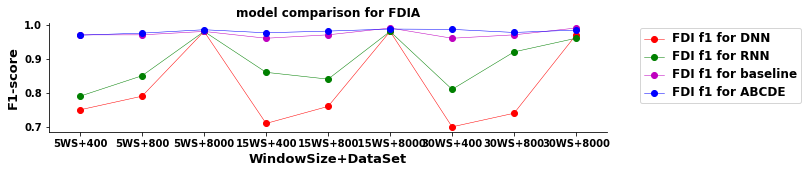

In [ ]:
from matplotlib.docstring import dedent_interpd
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Arial']#如果要显示中文字体，则在此处设为：SimHei
plt.rcParams['axes.unicode_minus']=False#显示负号

x = np.array([3,5,7,9,11,13,15,17,19])
noABC = np.array([0.958,0.963, 0.967, 0.957, 0.961, 0.966, 0.961, 0.963, 0.97])
deABC= np.array([0.709, 0.747, 0.796, 0.75, 0.785, 0.831, 0.795, 0.834, 0.885])
FDABC=np.array([0.969,0.975,0.985,0.976,0.981,0.987,0.986,0.977,0.984])
noDNN=np.array([0.9,0.94,0.96,0.87,0.89,0.97,0.81,0.86,0.96])
deDNN=np.array([0.26,0.47,0.74,0.14,0.3,0.81,0.2,0.29,0.81])
FDDNN=np.array([0.75,0.79,0.98,0.71,0.76,0.98,0.7,0.74,0.97])
noLST=np.array([0.94,0.95,0.96,0.93,0.93,0.97,0.91,0.93,0.97])
deLST=np.array([0.09,0.16,0.7,0.16,0.12,0.84,0.18,0.56,0.88])
FDLST=np.array([0.79,0.85,0.98,0.86,0.84,0.98,0.81,0.92,0.96])
noRF=np.array([0.97,0.96,0.97,0.96,0.96,0.97,0.96,0.96,0.97])
deRF=np.array([0.68,0.71,0.78,0.71,0.77,0.82,0.74,0.78,0.85])
FDRF=np.array([0.97,0.97,0.98,0.96,0.97,0.99,0.96,0.97,0.99])






#label在图示(legend)中显示。若为数学公式，则最好在字符串前后添加"$"符号
#color：b:blue、g:green、r:red、c:cyan、m:magenta、y:yellow、k:black、w:white、、、
#线型：-  --   -.  :    ,
#marker：.  ,   o   v    <    *    +    1
plt.figure(figsize=(10,2))
# plt.grid(linestyle = "--") #设置背景网格线为虚线
ax = plt.gca()
ax.spines['top'].set_visible(False) #去掉上边框
ax.spines['right'].set_visible(False) #去掉右边框


# plt.plot(x,noDNN,color="red",label="normal f1 for DNN",marker='o',linewidth=0.5)
# plt.plot(x,deDNN,"r-",label="delay f1 for DNN",marker='o',linewidth=0.5)
plt.plot(x,FDDNN,"r-",label="FDI f1 for DNN",marker='o',linewidth=0.5)
# plt.plot(x,noLST,color="green",label="normal f1 for RNN",marker='o',linewidth=0.5)
# plt.plot(x,deLST,"g-",label="delay f1 for RNN",marker='o',linewidth=0.5)
plt.plot(x,FDLST,"g-",label="FDI f1 for RNN",marker='o',linewidth=0.5)
# plt.plot(x,noRF,color="m",label="normal f1 for baseline",marker='o',linewidth=0.5)
# plt.plot(x,deRF,"m-",label="delay f1 for baseline",marker='o',linewidth=0.5)
plt.plot(x,FDRF,"m-",label="FDI f1 for baseline",marker='o',linewidth=0.5)
# plt.plot(x,noABC,color="blue",label="normal f1 for ABCDE",marker='o',linewidth=0.5)
# plt.plot(x,deABC,"b-",label="delay f1 for ABCDE",marker='o',linewidth=0.5)
plt.plot(x,FDABC,"b-",label="FDI f1 for ABCDE",marker='o',linewidth=0.5)
group_labels=['5WS+400','5WS+800','5WS+8000','15WS+400','15WS+800',' 15WS+8000','30WS+400','30WS+800','30WS+8000'] #x轴刻度的标识
plt.xticks(x,group_labels,fontsize=10,fontweight='bold') #默认字体大小为10
plt.yticks(fontsize=10,fontweight='bold')
plt.title("model comparison for FDIA",fontsize=12,fontweight='bold') #默认字体大小为12
plt.xlabel("WindowSize+DataSet",fontsize=13,fontweight='bold')
plt.ylabel("F1-score",fontsize=13,fontweight='bold')
plt.xlim(2,20) #设置x轴的范围
# plt.ylim(0.7,1)

#plt.legend()          #显示各曲线的图例
plt.legend(bbox_to_anchor=(1.05, 1), numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12,fontweight='bold') #设置图例字体的大小和粗细

plt.savefig('D:\\filename.png') #建议保存为svg格式，再用inkscape转为矢量图emf后插入word中
plt.show()

In [ ]:
noABC = np.array([0.958,0.963, 0.967, 0.957, 0.961, 0.966, 0.961, 0.963, 0.97])
deABC= np.array([0.709, 0.747, 0.796, 0.75, 0.785, 0.831, 0.795, 0.834, 0.885])
FDABC=np.array([0.969,0.975,0.985,0.976,0.981,0.987,0.986,0.977,0.984])
noDNN=np.array([0.9,0.94,0.96,0.87,0.89,0.97,0.81,0.86,0.96])
deDNN=np.array([0.26,0.47,0.74,0.14,0.3,0.81,0.2,0.29,0.81])
FDDNN=np.array([0.75,0.79,0.98,0.71,0.76,0.98,0.7,0.74,0.97])
noLST=np.array([0.94,0.95,0.96,0.93,0.93,0.97,0.91,0.93,0.97])
deLST=np.array([0.09,0.16,0.7,0.16,0.12,0.84,0.18,0.56,0.88])
FDLST=np.array([0.79,0.85,0.98,0.86,0.84,0.98,0.81,0.92,0.96])
noRF=np.array([0.97,0.96,0.97,0.96,0.96,0.97,0.96,0.96,0.97])
deRF=np.array([0.68,0.71,0.78,0.71,0.77,0.82,0.74,0.78,0.85])
FDRF=np.array([0.97,0.97,0.98,0.96,0.97,0.99,0.96,0.97,0.99])

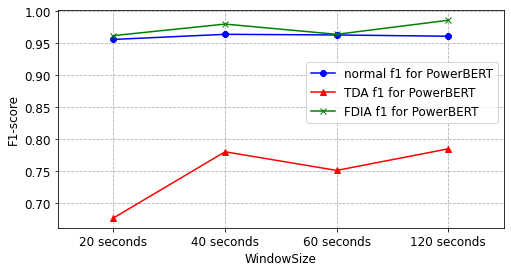

In [ ]:
from matplotlib.docstring import dedent_interpd
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Arial']#如果要显示中文字体，则在此处设为：SimHei
plt.rcParams['axes.unicode_minus']=False#显示负号

x = np.array([3,5,7,9])
noABC=np.array([0.956,0.964,0.963,0.961])
deABC=np.array([0.677,0.7804,0.75125,0.785])
FDABC=np.array([0.962,0.98,0.964,0.986])
# noDNN=np.array([0.9367,0.9533,0.9600])
# deDNN=np.array([0.5867,0.6767,0.7700])
# FDDNN=np.array([0.8567,0.9167,0.9767])
# noLST=np.array([0.9467,0.9600,0.9650])
# deLST=np.array([0.5767,0.7233,0.8050])
# FDLST=np.array([0.9400,0.9667,0.9850])
# noRF=np.array([0.96,0.9633,0.97])
# deRF=np.array([0.7267,0.75,0.8167])
# FDRF=np.array([0.9633,0.9800,0.99])
# noDB=np.array([0.96,0.9633,0.97])
# DEDB=np.array([0.7033,0.74,0.81])
# FDDB=np.array([0.96,0.97,0.9833])

# ABC


#label在图示(legend)中显示。若为数学公式，则最好在字符串前后添加"$"符号
#color：b:blue、g:green、r:red、c:cyan、m:magenta、y:yellow、k:black、w:white、、、
#线型：-  --   -.  :    ,
#marker：.  ,   o   v    <    *    +    1
plt.figure(figsize=(8,4))
plt.grid(linestyle = "--") #设置背景网格线为虚线
ax = plt.gca()
# ax.spines['top'].set_visible(False) #去掉上边框
# ax.spines['right'].set_visible(False) #去掉右边框


# plt.plot(x,noDNN,color="red",label="normal f1 for DNN",marker='o',linewidth=0.5)
# plt.plot(x,deDNN,"r--",label="delay f1 for DNN",marker='o',linewidth=0.5)
# plt.plot(x,FDDNN,"r:",label="FDI f1 for DNN",marker='o',linewidth=0.5)
# plt.plot(x,noLST,color="green",label="normal f1 for RNN",marker='o',linewidth=0.5)
# plt.plot(x,deLST,"g--",label="delay f1 for RNN",marker='o',linewidth=0.5)
# plt.plot(x,FDLST,"g:",label="FDI f1 for RNN",marker='o',linewidth=0.5)
# plt.plot(x,noRF,color="m",label="normal f1 for baseline",marker='o',linewidth=0.5)
# plt.plot(x,deRF,"m--",label="delay f1 for baseline",marker='o',linewidth=0.5)
# plt.plot(x,FDRF,"m:",label="FDI f1 for baseline",marker='o',linewidth=0.5)
# plt.plot(x,noDB,color="y",label="normal f1 for DBRF",marker='o',linewidth=0.5)
# plt.plot(x,DEDB,"y--",label="delay f1 for DBRF",marker='o',linewidth=0.5)
# plt.plot(x,FDDB,"y:",label="FDI f1 for DBRF",marker='o',linewidth=0.5)
plt.plot(x,noABC,color="blue",label="normal f1 for PowerBERT",marker='8',linewidth=1.5)
plt.plot(x,deABC,"r",label="TDA f1 for PowerBERT",marker='^',linewidth=1.5)
plt.plot(x,FDABC,"g",label="FDIA f1 for PowerBERT",marker='x',linewidth=1.5)
group_labels=['20 seconds','40 seconds','60 seconds','120 seconds'] #x轴刻度的标识
plt.xticks(x,group_labels,fontsize=12) #默认字体大小为10
plt.yticks(fontsize=12)
# plt.title("model comparison for different sliding window size",fontsize=12) #默认字体大小为12
plt.xlabel("WindowSize",fontsize=12)
plt.ylabel("F1-score",fontsize=12)
plt.xlim(2,10) #设置x轴的范围
# plt.ylim(0.7,1)

#plt.legend()          #显示各曲线的图例
plt.legend( numpoints=1,bbox_to_anchor=(1,0.79),fontsize=12)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) #设置图例字体的大小和粗细

plt.savefig('D:\\filename.png') #建议保存为svg格式，再用inkscape转为矢量图emf后插入word中
plt.show()

In [ ]:
df=df.iloc[:,1:]
df

,y,comp-1,comp-2
0,0.0,48.426727,-4.943856
1,0.0,25.988058,8.075758
2,0.0,26.467619,-13.915829
3,0.0,47.464600,-7.076348
4,0.0,30.704700,16.805761
...,...,...,...
1495,2.0,-41.768450,-25.840117
1496,2.0,-45.698166,-13.518312
1497,2.0,-34.150350,-13.064112
1498,2.0,-38.315067,-25.219673


In [20]:
df=df.iloc[:,2:]
df

,y,comp-1,comp-2
0,0.0,48.426727,-4.943856
1,0.0,25.988058,8.075758
2,0.0,26.467619,-13.915829
3,0.0,47.464600,-7.076348
4,0.0,30.704700,16.805761
...,...,...,...
1495,2.0,-41.768450,-25.840117
1496,2.0,-45.698166,-13.518312
1497,2.0,-34.150350,-13.064112
1498,2.0,-38.315067,-25.219673


      Unnamed: 0  Unnamed: 0.1    y     comp-1     comp-2
0              0        649666  0.0  48.426727  -4.943856
1              1        537651  0.0  25.988058   8.075758
2              2        308111  0.0  26.467619 -13.915829
3              3        220065  0.0  47.464600  -7.076348
4              4        491796  0.0  30.704700  16.805761
...          ...           ...  ...        ...        ...
1495        1495         18359  2.0 -41.768450 -25.840117
1496        1496         65146  2.0 -45.698166 -13.518312
1497        1497        182408  2.0 -34.150350 -13.064112
1498        1498         92963  2.0 -38.315067 -25.219673
1499        1499          4986  2.0 -38.815212 -25.774406

[1500 rows x 5 columns]


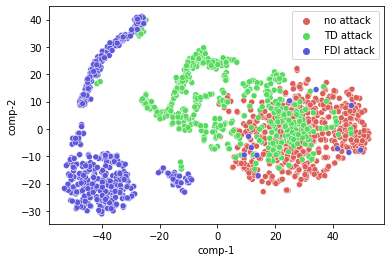

In [33]:
from sklearn.manifold import TSNE
from keras.datasets import mnist
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from numpy import reshape
import seaborn as sns
import pandas as pd 
df=pd.read_csv('/content/drive/MyDrive/ADSC/tsne.csv')
# pca = PCA(n_components=2)
print(df)
for i in range(df.shape[0]):
  if df.iloc[i,2]==1:
    df.iloc[i,2]='TD attack'
  elif df.iloc[i,2]==0:
    df.iloc[i,2]='no attack'
  elif df.iloc[i,2]==2:
    df.iloc[i,2]='FDI attack'
df
fig, ax = plt.subplots()
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y,palette=sns.color_palette("hls", 3),
               data=df.iloc[:,1:])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:])

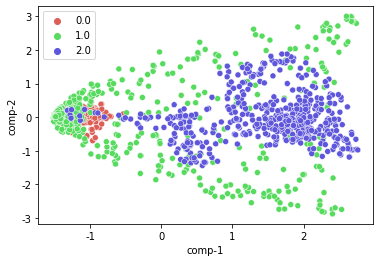

In [ ]:
from sklearn.manifold import TSNE
from keras.datasets import mnist
from sklearn.datasets import load_iris
from numpy import reshape
import seaborn as sns
import pandas as pd 
df=pd.read_csv('/content/drive/MyDrive/ADSC/pca.csv')
# pca = PCA(n_components=2)


sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),data=df)